In [175]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from util import get_data, get_data2, plot_data, symbol_to_path
import datetime as dt
from matplotlib import gridspec
import RTLearner as rt
from marketsim import compute_portvals, portfolio_stat

# %matplotlib inline

import matplotlib
matplotlib.rcParams.update({'font.size': 22})


# calculate and return normalized dataframe
def normalize(df):
    #result = pd.DataFrame({'Normalized Price': df / df.ix[0]})
    return df / df.ix[0]

# calculate and return standardized dataframe
def standardize(df):
    return (df-df.mean(axis=0))/df.std(axis=0)

# calculate and return dataframe of simple moving average
def SMA(df, window=2):
    SMA = pd.DataFrame({'SMA':df.rolling(window).mean()})
    return SMA


# calculate and return dataframe of Bollinger Bands
def BB(df, window=20):
    n = 2
    average = df.rolling(window).mean()
    std = df.rolling(window).std()
    upper = average + n * std
    lower = average - n * std
    percentage = (df-lower)/(upper-lower)
    result = pd.DataFrame({'BB_upper': upper, 'BB_lower': lower, 'BB_%': percentage})
    return result


# calculate and return dataframe of Moving Average Convergence Divergence
def MACD(df, n_fast=12, n_slow=26, n_macd=9):
    ema_slow = df.ewm(ignore_na=False, span=n_slow, min_periods=1, adjust=True).mean()
    ema_fast = df.ewm(ignore_na=False, span=n_fast, min_periods=1, adjust=True).mean()
    MACD = (ema_fast-ema_slow).ewm(ignore_na=False, span=n_macd, min_periods=1, adjust=True).mean()
    result = pd.DataFrame({'MACD': MACD})
    return result


# calculate and return dataframe of Relative Strength Index
def RSI(df, window):
    delta = df.diff()
    up = delta.copy()
    up[up < 0] = 0
    down = delta.copy()
    down[down > 0] = 0
    rolling_up = up.rolling(window).mean()
    rolling_down = down.rolling(window).mean()
    RS = rolling_up / rolling_down.abs()
    RSI = 100.0 - (100.0 / (1.0 + RS))
    result = pd.DataFrame({'RSI': RSI})
    return result


# calculate and return dataframe of On Balane Volume
def OBV(df_price, df_volume):
    OBV = df_price.copy()
    OBV[:] = 0
    delta = df_price.diff()
    for i in range(1, df_price.shape[0]):
        if delta[i] > 0:
            OBV.ix[i] = OBV.ix[i-1] + df_volume.ix[i, 1]
        elif delta[i] < 0:
            OBV.ix[i] = OBV.ix[i-1] - df_volume.ix[i, 1]
        elif delta[i] == 0:
            OBV.ix[i] = OBV.ix[i-1] + 0

    result = pd.DataFrame({'OBV': OBV},dtype=int)
    return result

def author():
    return 'zzhao38'

In [176]:
# in sample start and end dates
sd_train = dt.datetime(2008, 1, 1)
ed_train = dt.datetime(2009, 12, 31)

# out of sample start and end dates
sd_test = dt.datetime(2010, 1, 1)
ed_test = dt.datetime(2011, 12, 31)

# temporary start and end dates to get rid of NaN
sd_temp = dt.datetime(2007,11,1)
ed_temp = dt.datetime(2011,12,31)

dates_train = pd.date_range(sd_train, ed_train)
dates_test = pd.date_range(sd_test, ed_test)
dates_temp = pd.date_range(sd_temp,ed_temp)

symbols = ['AAPL']

# df_train = get_data2(symbols, dates_train)
# df_test = get_data2(symbols, dates_test)
df_temp = get_data2(symbols,dates_temp)

df_temp_price = df_temp.ix[:,0]
df_temp_volume = df_temp.ix[:,1]

df_temp_price = normalize(df_temp_price)

df_train_price_norm = normalize(df_temp_price.ix[dates_train].dropna())

sma = normalize(SMA(df_temp_price, 20).ix[dates_train,:].dropna())

price_to_sma = standardize(pd.DataFrame(df_train_price_norm)/sma.values)
bb = standardize(BB(df_temp_price, 20)).ix[dates_train,:].dropna()
macd = standardize(MACD(df_temp_price)).ix[dates_train,:].dropna()
rsi = standardize(RSI(df_temp_price, 10)).ix[dates_train,:].dropna()
obv = standardize(OBV(df_temp_price, df_temp_volume)).ix[dates_train,:].dropna()



In [202]:
X_train = pd.concat([price_to_sma, bb['BB_%'], macd, rsi, obv],axis=1)
X_train.columns = ['Price/SMA', '%BB', 'MACD', 'RSI', 'OBV']

# define lower and upper bounds of buy and sell signal based on 5 criterias
BUY_criteria = [-1,-1,-2,-1.5,-1]
SELL_criteria = [1.5,1.5,1,-0.25,1.25]

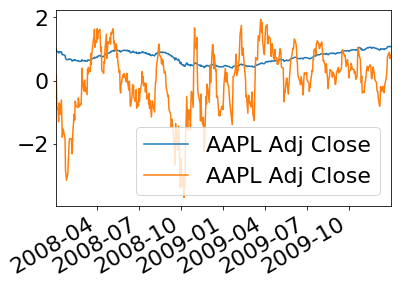

In [203]:
pd.concat([df_train_price_norm,price_to_sma],axis=1).plot()

In [204]:
# construct a matrix of those buy and sell signals for each trading day
X_criteria = X_train.copy().as_matrix()
for i in range(5):
    X_criteria[X_criteria[:,i] <= BUY_criteria[i],i] = 1.0
    X_criteria[X_criteria[:,i] >= SELL_criteria[i],i] = -1.0
X_criteria[(X_criteria != 1.0) & (X_criteria != -1.0)] = 0.0

In [282]:
# construct orderbook based on signal matrix
order_rule = pd.DataFrame()
order_rule = order_rule.append({'Date':X_train.index[0], 'Symbol':'AAPL', 'Order':'BUY', 'Shares':0}, \
                                   ignore_index=True)
LONG_date = pd.DataFrame()
SHORT_date = pd.DataFrame()
for i in range(int((X_train.shape[0]-1)/21)):
    # if total number of buy signal - total number of sell signal > = 2, then buy
    if X_criteria[i].sum() >= 2.0:
        order_rule = order_rule.append({'Date':X_train.index[int(i*21)], 'Symbol':'AAPL', 'Order':'BUY', 'Shares':200}, \
                                   ignore_index=True)
        order_rule = order_rule.append({'Date':X_train.index[int(i*21)+21], 'Symbol':'AAPL', 'Order':'SELL', 'Shares':200}, \
                                   ignore_index=True)
        LONG_date = LONG_date.append({'Date':X_train.index[int(i*21)]}, ignore_index=True)
    # if total number of buy signal - total number of sell signal < = -1, then sell
    elif X_criteria[i].sum() <= -1.0:
        order_rule = order_rule.append({'Date':X_train.index[int(i*21)], 'Symbol':'AAPL', 'Order':'SELL', 'Shares':200}, \
                                   ignore_index=True)
        order_rule = order_rule.append({'Date':X_train.index[int(i*21)+21], 'Symbol':'AAPL', 'Order':'BUY', 'Shares':200}, \
                                   ignore_index=True)
        SHORT_date = SHORT_date.append({'Date':X_train.index[int(i*21)]}, ignore_index=True)
        
order_rule = order_rule.append({'Date':X_train.index[-1], 'Symbol':'AAPL', 'Order':'BUY', 'Shares':0}, \
                                   ignore_index=True)
        
order_rule.index = order_rule['Date']
del order_rule['Date']

# save as .csv file
order_rule.to_csv('./orders/order_rule.csv')

# compute portfolio stats using orderbook
portfolio_benchmark = compute_portvals('./orders/order_benchmark.csv', start_val=100000)
portfolio_rule = compute_portvals('./orders/order_rule.csv', start_val=100000)

In [283]:
LONG_date = LONG_date.as_matrix()
SHORT_date = SHORT_date.as_matrix()

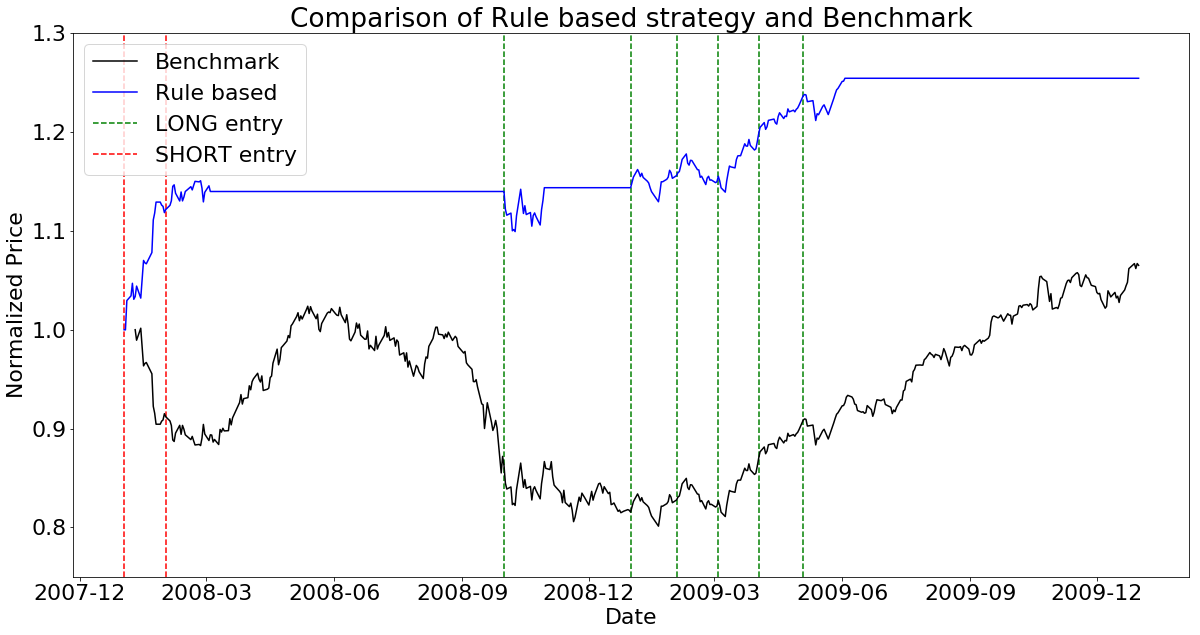

In [221]:
plt.figure(1, figsize=(20,10))
plt.plot(normalize(portfolio_benchmark), color='black')
plt.plot(normalize(portfolio_rule), color='blue')
plt.ylim([0.75,1.3])
plt.vlines(LONG_date,ymin=0.75,ymax=1.3, colors='green',linestyles='--')
plt.vlines(SHORT_date,ymin=0.75,ymax=1.3, colors='red',linestyles='--')
plt.xlabel('Date')
plt.ylabel('Normalized Price')
plt.title('Comparison of Rule based strategy and Benchmark')
plt.legend(['Benchmark','Rule based', 'LONG entry', 'SHORT entry'])
plt.show()

In [346]:
LONG_date = pd.DataFrame()
SHORT_date = pd.DataFrame()
for i in range(X_train.shape[0]):
    # if total number of buy signal - total number of sell signal > = 2, then buy
    if X_criteria[i].sum() >= 2.0:
        LONG_date = LONG_date.append({'Date':X_train.index[i]}, ignore_index=True)
    # if total number of buy signal - total number of sell signal < = -1, then sell
    elif X_criteria[i].sum() <= -1.0:
        SHORT_date = SHORT_date.append({'Date':X_train.index[i]}, ignore_index=True)

In [348]:

LONG_date = LONG_date.as_matrix()
SHORT_date = SHORT_date.as_matrix()

indicators = ['%BB','MACD']
long_indicators = pd.DataFrame()
short_indicators = pd.DataFrame()
hold_indicators = pd.DataFrame()
for i in range(LONG_date.shape[0]):
    long_indicators = long_indicators.append(X_train.ix[LONG_date[i],indicators])
for i in range(SHORT_date.shape[0]):
    short_indicators = short_indicators.append(X_train.ix[SHORT_date[i],indicators])
hold_indicators = X_train[indicators]

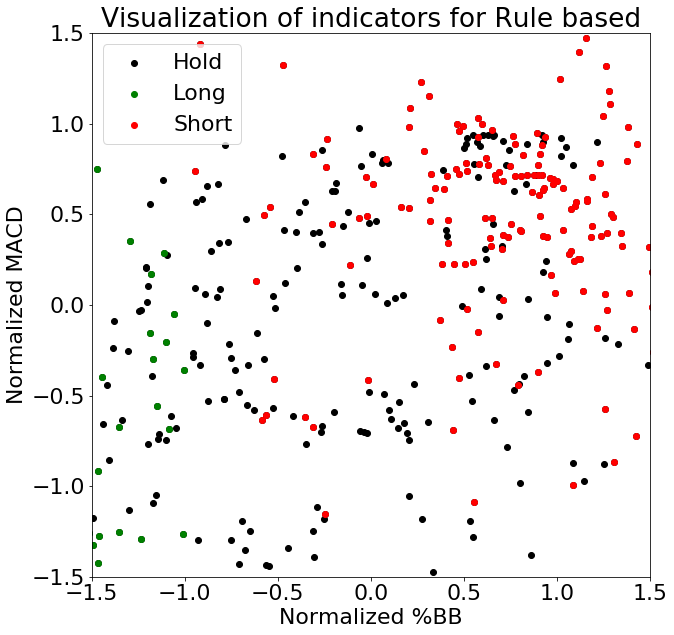

In [350]:
plt.figure(2, figsize=(10,10))
plt.scatter(hold_indicators['%BB'], hold_indicators['MACD'], color='black', )
plt.scatter(long_indicators['%BB'], long_indicators['MACD'], color='green')
plt.scatter(short_indicators['%BB'], short_indicators['MACD'], color='red')

plt.xlim([-1.5,1.5])
plt.ylim([-1.5,1.5])
plt.xlabel('Normalized %BB')
plt.ylabel('Normalized MACD')

plt.title('Visualization of indicators for Rule based')
plt.legend(['Hold','Long','Short'])
plt.show()